In [1]:
# coding: utf-8
import gym
import torch.utils.data as data
from dynamics import *
from controller import *
from utils import *
from quanser_robots.common import GentlyTerminating
import time

env_id = "CartpoleStabShort-v0"
env = GentlyTerminating(gym.make(env_id))
config_path = "config.yml"
config = load_config(config_path)
print_config(config_path)

************************
*** model configuration ***
load_model: true
model_path: storage/exp_1.ckpt
n_actions: 1
n_hidden: 1
n_states: 5
size_hidden: 512
use_cuda: true

*** train configuration ***
batch_size: 256
exp_number: 1
learning_rate: 0.001
n_epochs: 60
save_loss_fig: true
save_loss_fig_frequency: 10
save_model_flag: true
save_model_path: storage/exp_2.ckpt

************************
*** dataset configuration ***
load_flag: false
load_path: storage/data_exp_1.pkl
min_train_samples: 6000
mpc_dataset_split: 0.5
n_max_steps: 1000
n_mpc_episodes: 4
n_mpc_itrs: 100
n_random_episodes: 800
save_flag: true
save_path: storage/data_exp_1.pkl
testset_split: 0.2

************************
*** MPC controller configuration ***
action_high: 12
action_low: -12
gamma: 0.99
horizon: 8
max_itrs: 20
numb_bees: 8



/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/zuxin/Documents/projects/10708-project/ReinforcementLearning-DQN-MPC/MPC/MPC-CartPoleStab/utils.py:23: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)
/home/zuxin/Documents/projects/10708-project/ReinforcementLearning-DQN-MPC/MPC/MPC-CartPoleStab/utils.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
'''Initialize the dynamic model'''
model = DynamicModel(config)

'''Initialize the dataset factory class'''
data_fac = DatasetFactory(env,config)

'''Collect dataset randomly'''
data_fac.collect_random_dataset()

/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original so

Collect random dataset shape:  (131941, 6)


Total training step per epoch [413]


/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MLP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type

Epoch [10/60], Training Loss: 0.00277861, Test Loss: 0.00325792
Epoch [20/60], Training Loss: 0.00264000, Test Loss: 0.00259972
Epoch [30/60], Training Loss: 0.00257633, Test Loss: 0.00266951
Epoch [40/60], Training Loss: 0.00255300, Test Loss: 0.00289903
Epoch [50/60], Training Loss: 0.00250636, Test Loss: 0.00305991
Epoch [60/60], Training Loss: 0.00244984, Test Loss: 0.00261863


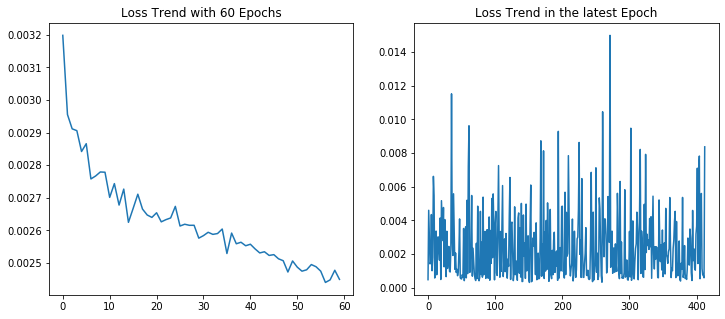

In [3]:
'''Train the dynamic model with the randomly collected dataset'''
loss = model.train(data_fac.random_trainset,data_fac.random_testset)

/home/zuxin/Documents/projects/10708-project/ReinforcementLearning-DQN-MPC/MPC/MPC-CartPoleStab/dynamics.py:61: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()


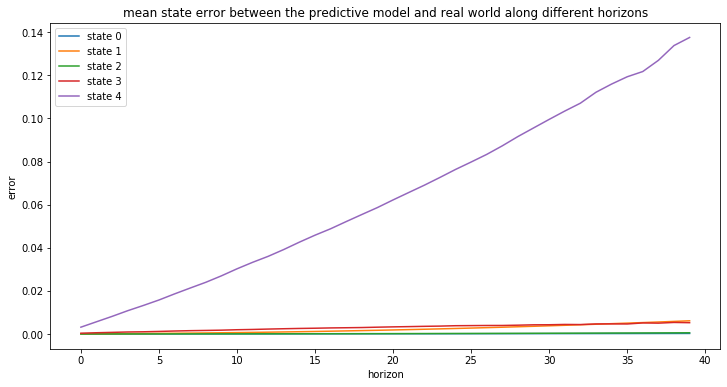

In [4]:
'''See the model errors along the horizon'''
model.plot_model_validation(env,n_sample=200,mode='mean')

In [5]:
'''Initialize the MPC controller'''
mpc = MPC(env,config)

In [6]:
'''Collect MPC based dataset, train the model, and iterate again and again'''
rewards_list = []
for itr in range(config["dataset_config"]["n_mpc_itrs"]):
    t = time.time()
    print("**********************************************")
    print("The reinforce process [%s], collecting data ..." % itr)
    
    '''Collect bootstrap dataset'''
    rewards = data_fac.collect_mpc_dataset(mpc,model,render=True)
    trainset, testset = data_fac.make_dataset()
    rewards_list += rewards
    
    plt.close("all")
    plt.figure(figsize=(12, 5))
    plt.title('Reward Trend with %s iteration' % itr)
    plt.plot(rewards_list)
    plt.savefig("storage/reward-" + str(model.exp_number) + ".png")
    print("Consume %s s in this iteration" % (time.time()-t))
    
    '''Retrain the model'''
    loss = model.train(trainset,testset)

**********************************************
The reinforce process [0], collecting data ...


KeyboardInterrupt: 